# Comparative Analysis of Gaussian Process and Random Forest Models for Predicting NEK9 Kinase Inhibitors and Binders in Drug Discovery


## Overview of Imports

This notebook imports a variety of libraries and modules essential for data handling, machine learning modeling, and visualization:
- **Data Manipulation**: `pandas`, `numpy`
- **Machine Learning**: `sklearn`, `imblearn`, `torch`
- **Chemoinformatics**: `rdkit`
- **Visualization**: `matplotlib`
- **Utility Scripts**: Custom utility modules for specific functions and visualizations.

These imports are organized in a separate script to keep the notebook clean and focused on analysis.


In [1]:
from imports import * 

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np

def smiles_to_fps(smiles_list, radius=2, nBits=2048):
    fps = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
            arr = np.zeros((1,), dtype=np.int8)
            Chem.DataStructs.ConvertToNumpyArray(fp, arr)
            fps.append(arr)
    return np.array(fps)

In [3]:
import torch
import gpytorch
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA

def GP_basic(trainX_np, trainY_np, testX_np, testY_np, method='None', train_iter=200):
    # Convert numpy arrays to PyTorch tensors
    trainX_torch = torch.from_numpy(trainX_np).float()
    testX_torch = torch.from_numpy(testX_np).float()
    trainY_torch = torch.from_numpy(trainY_np.astype("long")).reshape(-1)
    testY_torch = torch.from_numpy(testY_np.astype("long")).reshape(-1)
    
    # Apply sampling method
    if method == 'OS':
        oversample = SMOTE()
        trainX_np, trainY_np = oversample.fit_resample(trainX_np, trainY_np)
        trainX_torch = torch.from_numpy(trainX_np).float()
        trainY_torch = torch.from_numpy(trainY_np.astype("long")).reshape(-1)
    elif method == 'US':
        undersample = RandomUnderSampler()
        trainX_np, trainY_np = undersample.fit_resample(trainX_np, trainY_np)
        trainX_torch = torch.from_numpy(trainX_np).float()
        trainY_torch = torch.from_numpy(trainY_np.astype("long")).reshape(-1)
    
    # Initialize likelihood and model
    likelihood = gpytorch.likelihoods.DirichletClassificationLikelihood(trainY_torch, learn_additional_noise=True)
    model = DirichletGPModel(trainX_torch, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)
    
    # Train the model
    model.train()
    likelihood.train()
    
    # Define the optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    # Training loop
    for i in range(train_iter):
        optimizer.zero_grad()
        output = model(trainX_torch)
        loss = -mll(output, likelihood.transformed_targets).sum()
        loss.backward()
        optimizer.step()
        if i % 50 == 0:
            print(f'Iter {i + 1}/{train_iter} - Loss: {loss.item():.3f}')
    
    return model, testX_torch, testY_torch, method

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import numpy as np

def RF_basic(trainX_np, trainY_np, testX_np, testY_np, sampling='None', method='None'):
    # Apply sampling method
    if sampling == 'OS':
        oversample = SMOTE()
        trainX_np, trainY_np = oversample.fit_resample(trainX_np, trainY_np)
    elif sampling == 'US':
        undersample = RandomUnderSampler()
        trainX_np, trainY_np = undersample.fit_resample(trainX_np, trainY_np)

    # Initialize Random Forest model
    rf = RandomForestClassifier(random_state=42)
    
    # Define hyperparameter search if required
    if method == 'HyperPara':
        param_dist = {'n_estimators': randint(50, 300), 'max_depth': randint(1, 40)}
        search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=5, cv=3, scoring='accuracy')
        search.fit(trainX_np, trainY_np)
        best_model = search.best_estimator_
    elif method == 'GridSearch':
        param_grid = {
            'n_estimators': [100, 300, 500],  # Reduced number of points
            'max_depth': [10, 20, 30],  # Reduced range and points
            'min_samples_split': [2, 4],  # Reduced options
            'min_samples_leaf': [1, 2]  # Reduced options
        }
        search = GridSearchCV(rf, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
        search.fit(trainX_np, trainY_np)
        best_model = search.best_estimator_
    else:
        rf.fit(trainX_np, trainY_np)
        best_model = rf

    # Predict on the test set
    testY_pred = best_model.predict(testX_np)
    
    # Calculate and print accuracy
    accuracy = accuracy_score(testY_np, testY_pred)
    print(f"Test Accuracy: {accuracy:.2%}")
    
    # Determine the method string
    method_type = f"{sampling}_{method}" if method != 'None' else sampling

    return best_model, testX_np, testY_np, method_type

# Example usage:
# Assuming trainX_np, trainY_np, testX_np, testY_np are numpy arrays properly prepared
# rf_model, testX_np, testY_np, method_type = RF_basic(trainX_np, trainY_np, testX_np, testY_np, sampling='OS', method='HyperPara')

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import gpytorch
from sklearn.ensemble import RandomForestClassifier

def plot_heatmap(testX, testY, model, title):
    # Check if the model is a GP model or an RF model
    if isinstance(model, gpytorch.models.ExactGP):
        model.eval()
        with torch.no_grad():
            # Assuming model outputs a distribution from which we get probabilities
            test_dist = model(testX)
            pred_samples = test_dist.sample(torch.Size((256,))).exp()
            probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)
        # Extract probabilities for the "active" class
        active_probabilities = probabilities[1].numpy()
    elif isinstance(model, (RandomForestClassifier)):
        # RF model outputs probabilities using the `predict_proba` method
        active_probabilities = model.predict_proba(testX)[:, 1]  # Assuming class '1' is the positive class

    # Compute distance between predicted probabilities and actual labels
    actual_labels = testY.numpy() if isinstance(testY, torch.Tensor) else testY
    distances = np.abs(active_probabilities - actual_labels)

    # Separate distances into positive and negative
    positives = distances[actual_labels == 1]
    negatives = distances[actual_labels == 0]

    # Determine the size of the grid for negatives
    side_length_negatives = int(np.ceil(np.sqrt(len(negatives))))  # Calculate the side length of the grid for negatives

    # Create grids for negatives and a column for positives
    grid_negatives = np.full((side_length_negatives, side_length_negatives), np.nan)
    grid_positives = np.full((side_length_negatives, 1), np.nan)  # We match the height to the negative grid for alignment

    # Fill the grids
    grid_negatives.flat[:len(negatives)] = negatives
    grid_positives.flat[:len(positives)] = positives

    # Add a division line/column (use a distinct color or np.nan for clear division)
    division_line = np.full((side_length_negatives, 1), np.nan)  # Creates a nan-filled division column

    # Combine the grids with the division line for visualization
    combined_grid = np.hstack([grid_positives, division_line, grid_negatives])

    # Plotting
    plt.figure(figsize=(12, 10))  # Adjust size to accommodate the division line
    heatmap = plt.imshow(combined_grid, cmap='RdYlGn_r', origin='lower', aspect='auto', vmin=0, vmax=1)
    plt.colorbar(heatmap, label='Distance from Actual Label')
    plt.title(title)
    plt.yticks([])  # Optionally hide y-axis labels for clarity
    plt.xticks([0.5, 1.5 + side_length_negatives / 2], ['Actual Positives', 'Actual Negatives'])
    plt.show()

# Example usage
# Make sure testX and testY are prepared correctly and model is your trained model
# plot_heatmap(testX_torch, testY_torch, model, "Prediction Distance Heatmap")

## Data Import and Scaling

### Data Import
The datasets for NEK9 kinase binding and inhibition were loaded from the provided Berkeley datasets. These datasets are split into training and testing sets for both binding and inhibition activities, facilitating separate evaluations for each activity type.

### Data Scaling
StandardScaler from `sklearn.preprocessing` was employed to normalize the features of both binding and inhibition datasets. This scaling is crucial for removing potential bias due to differing scales of data features, which is especially important for models like Gaussian Processes and Random Forests that are sensitive to feature scaling. The scaling process involves fitting the scaler on the concatenated training and testing feature sets to ensure a uniform scale across all data used in model training and evaluation.


In [6]:
trainX_bind = pd.read_csv("../datasets/NEK_data_4Berkeley/NEK9/NEK9_binding_random_fold1_trainX.csv")
trainY_bind = pd.read_csv("../datasets/NEK_data_4Berkeley/NEK9/NEK9_binding_random_fold1_trainY.csv")
testX_bind = pd.read_csv("../datasets/NEK_data_4Berkeley/NEK9/NEK9_binding_random_fold1_testX.csv")
testY_bind = pd.read_csv("../datasets/NEK_data_4Berkeley/NEK9/NEK9_binding_random_fold1_testY.csv")

trainX_inhib = pd.read_csv("../datasets/NEK_data_4Berkeley/NEK9/NEK9_inhibition_random_fold1_trainX.csv")
trainY_inhib = pd.read_csv("../datasets/NEK_data_4Berkeley/NEK9/NEK9_inhibition_random_fold1_trainY.csv")
testX_inhib = pd.read_csv("../datasets/NEK_data_4Berkeley/NEK9/NEK9_inhibition_random_fold1_testX.csv")
testY_inhib = pd.read_csv("../datasets/NEK_data_4Berkeley/NEK9/NEK9_inhibition_random_fold1_testY.csv")

In [7]:
# Concatenation of Training and Testing Feature Sets:
x_bind = pd.concat([trainX_bind, testX_bind])
x_inhib = pd.concat([trainX_inhib, testX_inhib])

# Feature Scaling using StandardScaler:
scaling = StandardScaler()

scaling.fit(x_bind)
trainX_bind_moe = scaling.transform(trainX_bind)
testX_bind_moe = scaling.transform(testX_bind)

scaling.fit(x_inhib)
trainX_inhib_moe = scaling.transform(trainX_inhib)
testX_inhib_moe = scaling.transform(testX_inhib)

In [8]:
# Convert the Y datasets from pandas DataFrames to numpy arrays
trainY_bind_moe = trainY_bind.to_numpy().reshape(-1)
testY_bind_moe = testY_bind.to_numpy().reshape(-1)
trainY_inhib_moe = trainY_inhib.to_numpy().reshape(-1)
testY_inhib_moe = testY_inhib.to_numpy().reshape(-1)

In [9]:
bind_df = pd.read_csv('../datasets/NEK_data_4Berkeley/NEK9/NEK9_1_uM_min_50_pct_binding_5fold_random_imbalanced.csv')

bind_train = bind_df[bind_df['fold'] != 'fold5'].drop(columns=['fold'])
bind_test = bind_df[bind_df['fold'] == 'fold5'].drop(columns=['fold'])

inhib_df = pd.read_csv('../datasets/NEK_data_4Berkeley/NEK9/NEK9_1_uM_min_50_pct_inhibition_5fold_random_imbalanced.csv')

inhib_train = inhib_df[inhib_df['fold'] != 'fold5'].drop(columns=['fold'])
inhib_test = inhib_df[inhib_df['fold'] == 'fold5'].drop(columns=['fold'])

trainX_bind_smiles = bind_train['base_rdkit_smiles']
testX_bind_smiles = bind_test['base_rdkit_smiles']

trainX_bind_MF = smiles_to_fps(trainX_bind_smiles, radius=2)
testX_bind_MF = smiles_to_fps(testX_bind_smiles, radius=2)

trainX_inhib_smiles = inhib_train['base_rdkit_smiles']
testX_inhib_smiles = inhib_test['base_rdkit_smiles']

trainX_inhib_MF = smiles_to_fps(trainX_inhib_smiles, radius=2)
testX_inhib_MF = smiles_to_fps(testX_inhib_smiles, radius=2)

In [10]:
trainY_bind_MF = bind_train['active'].to_numpy().reshape(-1)
testY_bind_MF = bind_test['active'].to_numpy().reshape(-1)

trainY_inhib_MF = inhib_train['active'].to_numpy().reshape(-1)
testY_inhib_MF = inhib_test['active'].to_numpy().reshape(-1)

In [11]:
# Printing the shapes of the datasets
print("Shapes of Binding Data:")
print("trainX_bind_moe shape:", trainX_bind_moe.shape)
print("trainY_bind_moe shape:", trainY_bind_moe.shape)
print("testX_bind_moe shape:", testX_bind_moe.shape)
print("testY_bind_moe shape:", testY_bind_moe.shape)

print("\nShapes of Inhibition Data:")
print("trainX_inhib_moe shape:", trainX_inhib_moe.shape)
print("trainY_inhib_moe shape:", trainY_inhib_moe.shape)
print("testX_inhib_moe shape:", testX_inhib_moe.shape)
print("testY_inhib_moe shape:", testY_inhib_moe.shape)

Shapes of Binding Data:
trainX_bind_moe shape: (1126, 306)
trainY_bind_moe shape: (1126,)
testX_bind_moe shape: (283, 306)
testY_bind_moe shape: (283,)

Shapes of Inhibition Data:
trainX_inhib_moe shape: (313, 306)
trainY_inhib_moe shape: (313,)
testX_inhib_moe shape: (80, 306)
testY_inhib_moe shape: (80,)


In [12]:
# Printing the shapes of the datasets with Morgan Fingerprints
print("Shapes of Binding Data:")
print("trainX_bind_MF shape:", trainX_bind_MF.shape)
print("trainY_bind_MF shape:", trainY_bind_MF.shape)
print("testX_bind_MF shape:", testX_bind_MF.shape)
print("testY_bind_MF shape:", testY_bind_MF.shape)

print("\nShapes of Inhibition Data:")
print("trainX_inhib_MF shape:", trainX_inhib_MF.shape)
print("trainY_inhib_MF shape:", trainY_inhib_MF.shape)
print("testX_inhib_MF shape:", testX_inhib_MF.shape)
print("testY_inhib_MF shape:", testY_inhib_MF.shape)

Shapes of Binding Data:
trainX_bind_MF shape: (1128, 2048)
trainY_bind_MF shape: (1128,)
testX_bind_MF shape: (281, 2048)
testY_bind_MF shape: (281,)

Shapes of Inhibition Data:
trainX_inhib_MF shape: (315, 2048)
trainY_inhib_MF shape: (315,)
testX_inhib_MF shape: (78, 2048)
testY_inhib_MF shape: (78,)


## Gaussian Process Models

In [13]:
# Construct a GP classification model

from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

# We will use the simplest form of GP model, exact inference
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### SMOTE

In [14]:
# Imbalanced
model, testX_torch, testY_torch, method = GP_basic(trainX_bind_moe, trainY_bind_moe, testX_bind_moe, testY_bind_moe, method='None')

Iter 1/200 - Loss: 7.106
Iter 51/200 - Loss: 3.363
Iter 101/200 - Loss: 3.158
Iter 151/200 - Loss: 3.114


<Figure size 600x400 with 0 Axes>

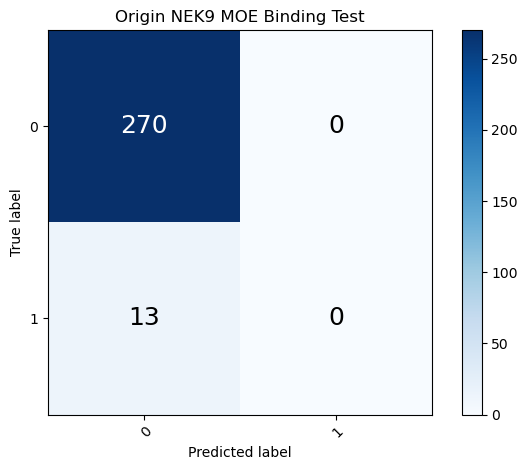

In [15]:
model.eval()

testY_pred = model(testX_torch).loc.max(0)[1].numpy()

plot_confusion_matrix(testY_bind_moe, testY_pred, ["0", "1"], title="Origin NEK9 MOE Binding Test")

We can see that as the training dataset is imbalanced, the performance of the model is poor, as no positive candidate was predicted. So, it is necessary for us to balance the training dataset, either using oversampling (SMOTE) or undersampling.

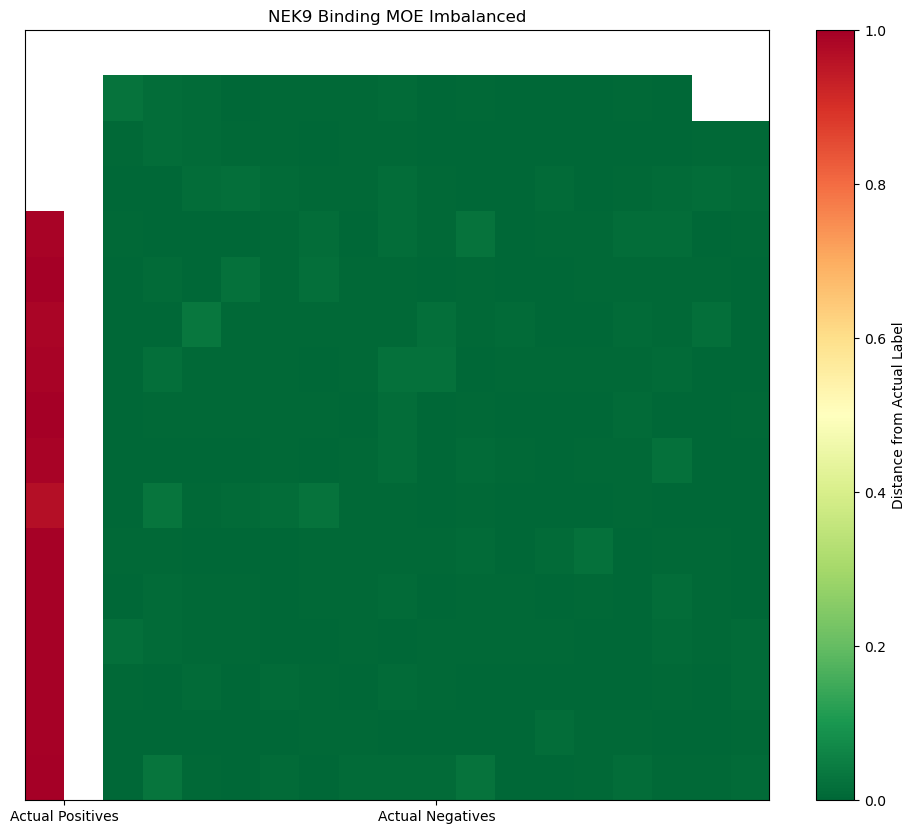

In [16]:
plot_heatmap(testX_torch, testY_torch, model, "NEK9 Binding MOE Imbalanced")

Iter 1/200 - Loss: 6.859
Iter 51/200 - Loss: 3.819
Iter 101/200 - Loss: 3.376
Iter 151/200 - Loss: 3.352


<Figure size 600x400 with 0 Axes>

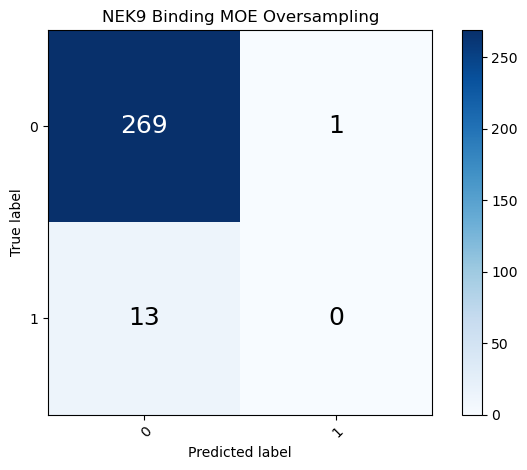

In [17]:
model, testX_torch, testY_torch, method = GP_basic(trainX_bind_moe, trainY_bind_moe, testX_bind_moe, testY_bind_moe, method='OS')
model.eval()
testY_pred = model(testX_torch).loc.max(0)[1].numpy()
plot_confusion_matrix(testY_bind_moe, testY_pred, ["0", "1"], title="NEK9 Binding MOE Oversampling")

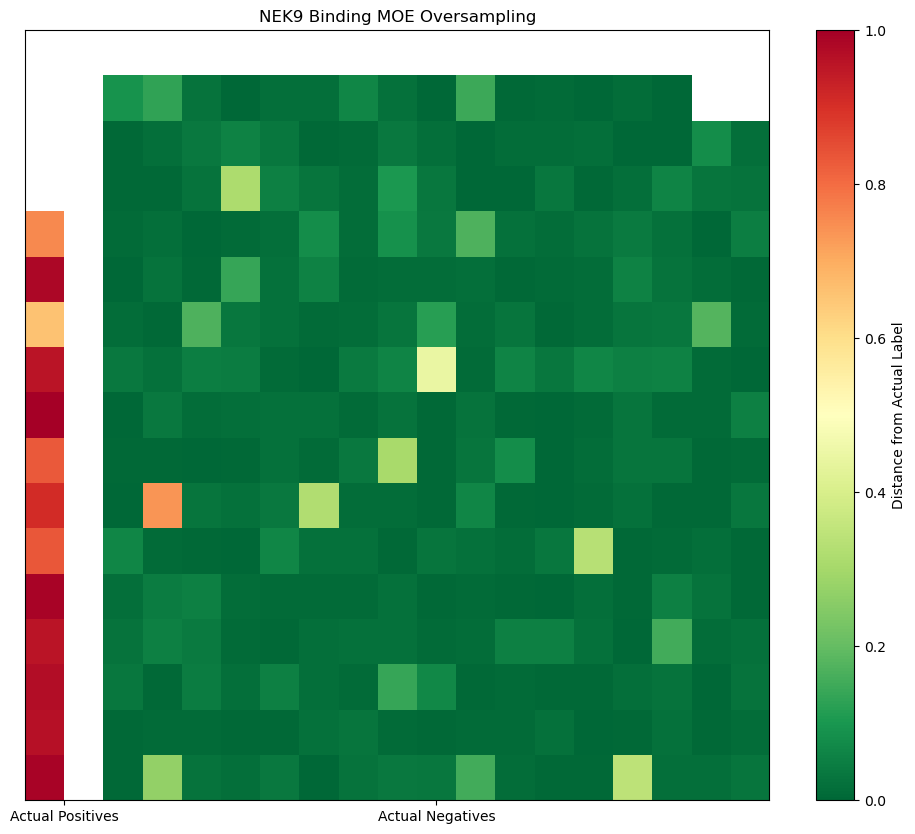

In [18]:
plot_heatmap(testX_torch, testY_torch, model, "NEK9 Binding MOE Oversampling")

Iter 1/200 - Loss: 7.107
Iter 51/200 - Loss: 5.208
Iter 101/200 - Loss: 5.202
Iter 151/200 - Loss: 5.202


<Figure size 600x400 with 0 Axes>

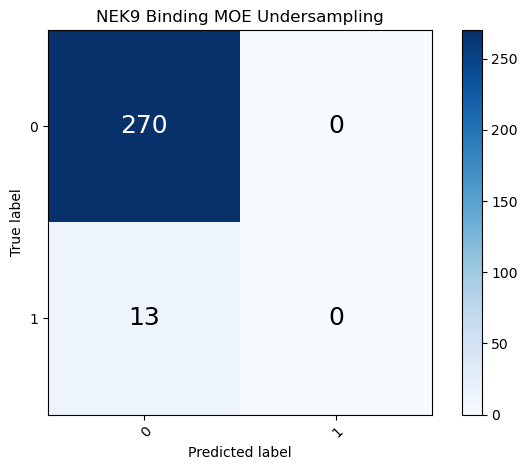

In [19]:
model, testX_torch, testY_torch, method = GP_basic(trainX_bind_moe, trainY_bind_moe, testX_bind_moe, testY_bind_moe, method='US')
model.eval()
testY_pred = model(testX_torch).loc.max(0)[1].numpy()
plot_confusion_matrix(testY_bind_moe, testY_pred, ["0", "1"], title="NEK9 Binding MOE Undersampling")

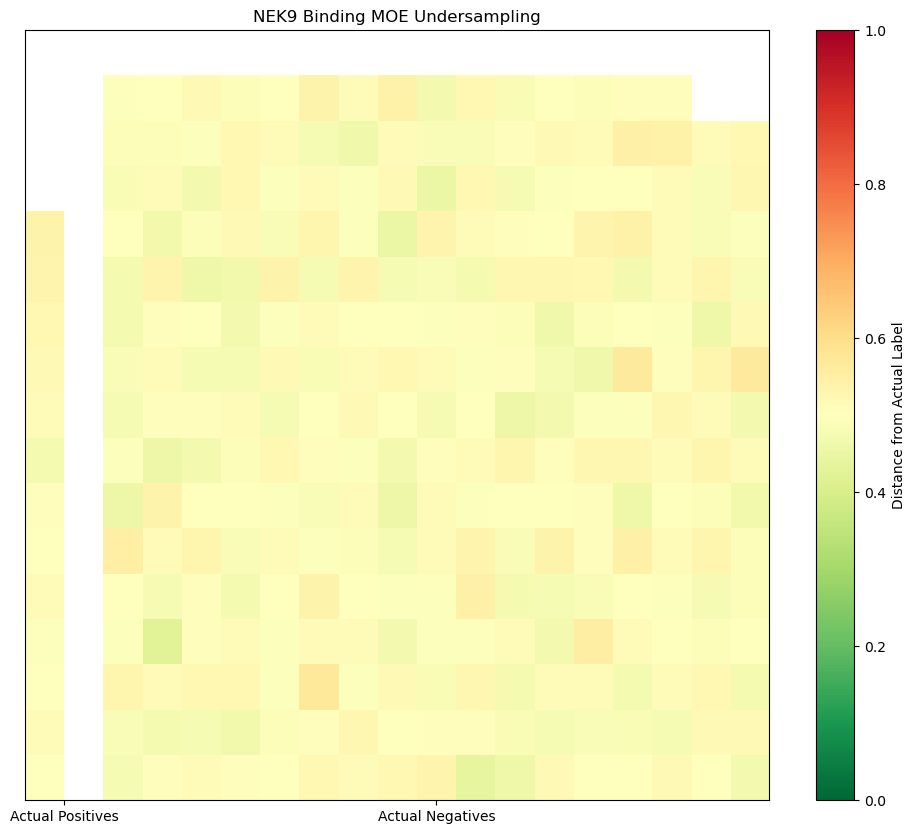

In [20]:
plot_heatmap(testX_torch, testY_torch, model, "NEK9 Binding MOE Undersampling")

Iter 1/200 - Loss: 7.107
Iter 51/200 - Loss: 5.208
Iter 101/200 - Loss: 5.202
Iter 151/200 - Loss: 5.202


<Figure size 600x400 with 0 Axes>

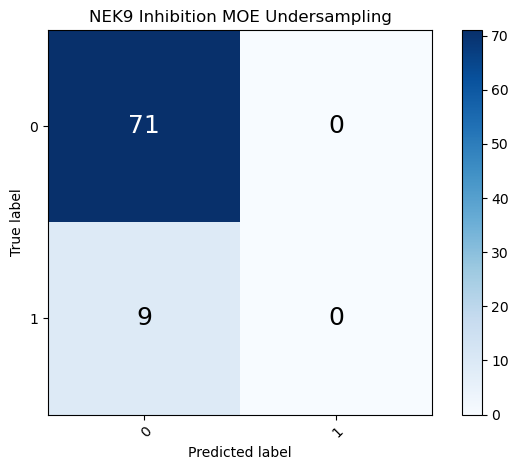

In [21]:
model, testX_torch, testY_torch, method = GP_basic(trainX_inhib_moe, trainY_inhib_moe, testX_inhib_moe, testY_inhib_moe, method='US')
model.eval()
testY_pred = model(testX_torch).loc.max(0)[1].numpy()
plot_confusion_matrix(testY_inhib_moe, testY_pred, ["0", "1"], title="NEK9 Inhibition MOE Undersampling")

Iter 1/200 - Loss: 6.984
Iter 51/200 - Loss: 4.057
Iter 101/200 - Loss: 3.461
Iter 151/200 - Loss: 3.411


<Figure size 600x400 with 0 Axes>

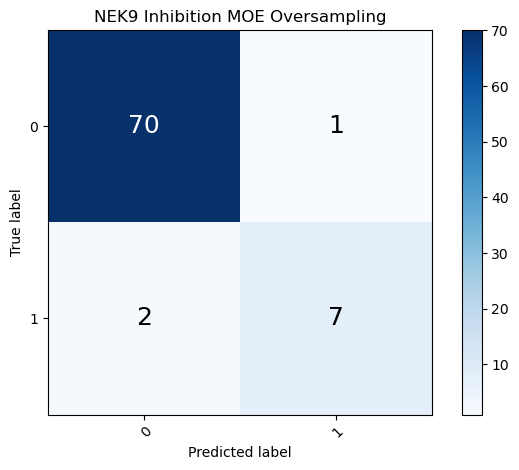

In [22]:
model, testX_torch, testY_torch, method = GP_basic(trainX_inhib_moe, trainY_inhib_moe, testX_inhib_moe, testY_inhib_moe, method='OS')
model.eval()
testY_pred = model(testX_torch).loc.max(0)[1].numpy()
plot_confusion_matrix(testY_inhib_moe, testY_pred, ["0", "1"], title="NEK9 Inhibition MOE Oversampling")

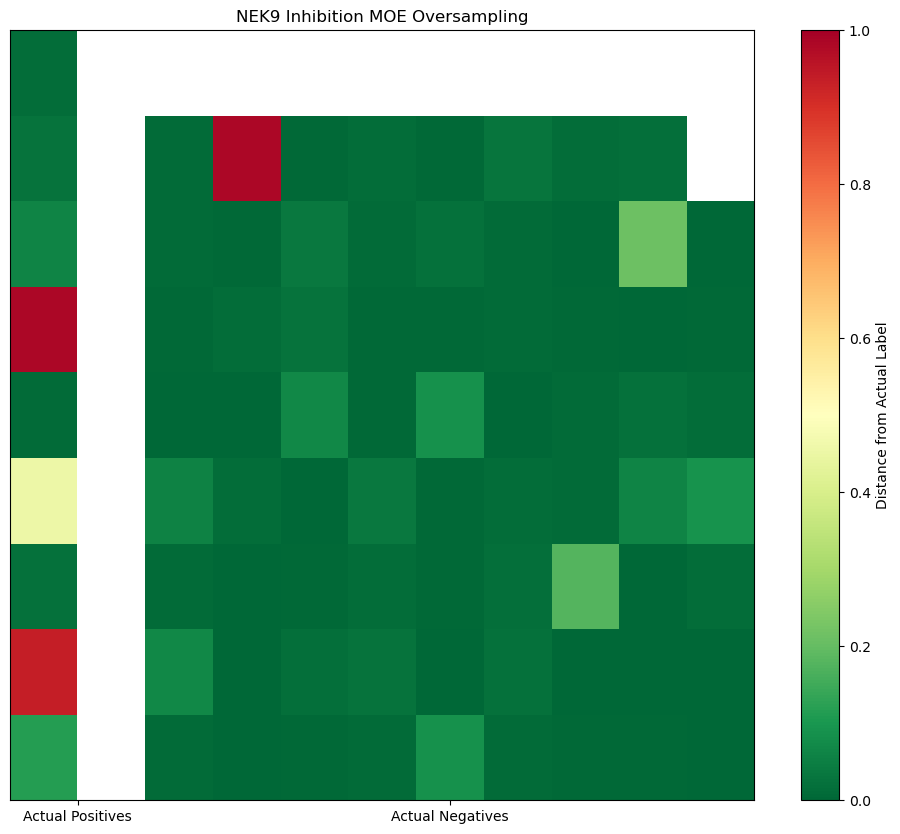

In [23]:
plot_heatmap(testX_torch, testY_torch, model, "NEK9 Inhibition MOE Oversampling")

In [24]:
# Morgan Fingerprint
model, testX_torch, testY_torch, method = GP_basic(trainX_bind_MF, trainY_bind_MF, testX_bind_MF, testY_bind_MF, method='OS')

Iter 1/200 - Loss: 6.140
Iter 51/200 - Loss: 3.368
Iter 101/200 - Loss: 3.263
Iter 151/200 - Loss: 3.254


<Figure size 600x400 with 0 Axes>

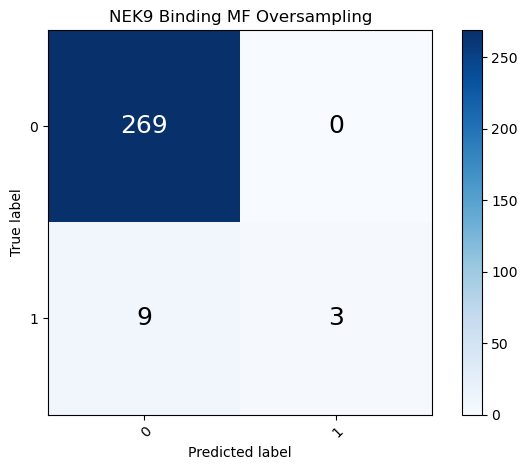

In [25]:
model.eval()
testY_pred = model(testX_torch).loc.max(0)[1].numpy()
plot_confusion_matrix(testY_bind_MF, testY_pred, ["0", "1"], title="NEK9 Binding MF Oversampling")

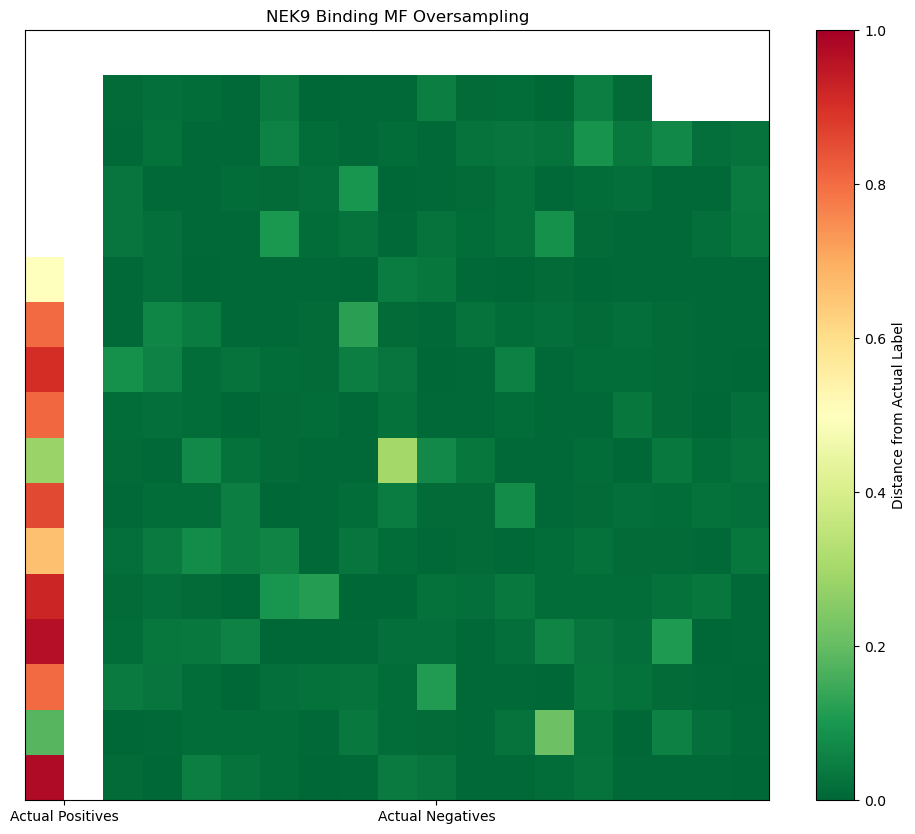

In [26]:
plot_heatmap(testX_torch, testY_torch, model, "NEK9 Binding MF Oversampling")

## Random Forest

Test Accuracy: 95.41%


<Figure size 600x400 with 0 Axes>

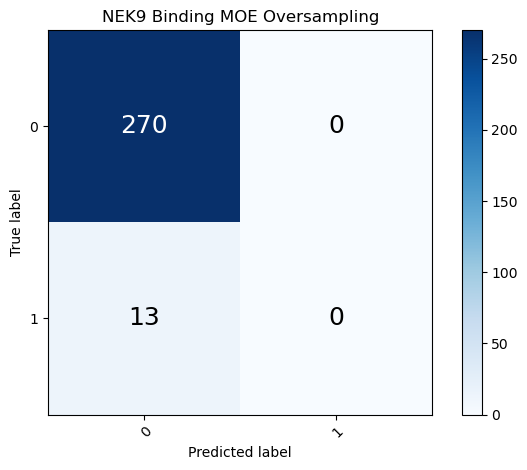

In [27]:
model, testX_torch, testY_torch, method = RF_basic(trainX_bind_moe, trainY_bind_moe, testX_bind_moe, testY_bind_moe, method='OS')
testY_pred = model.predict(testX_torch)
plot_confusion_matrix(testY_bind_moe, testY_pred, ["0", "1"], title="NEK9 Binding MOE Oversampling")

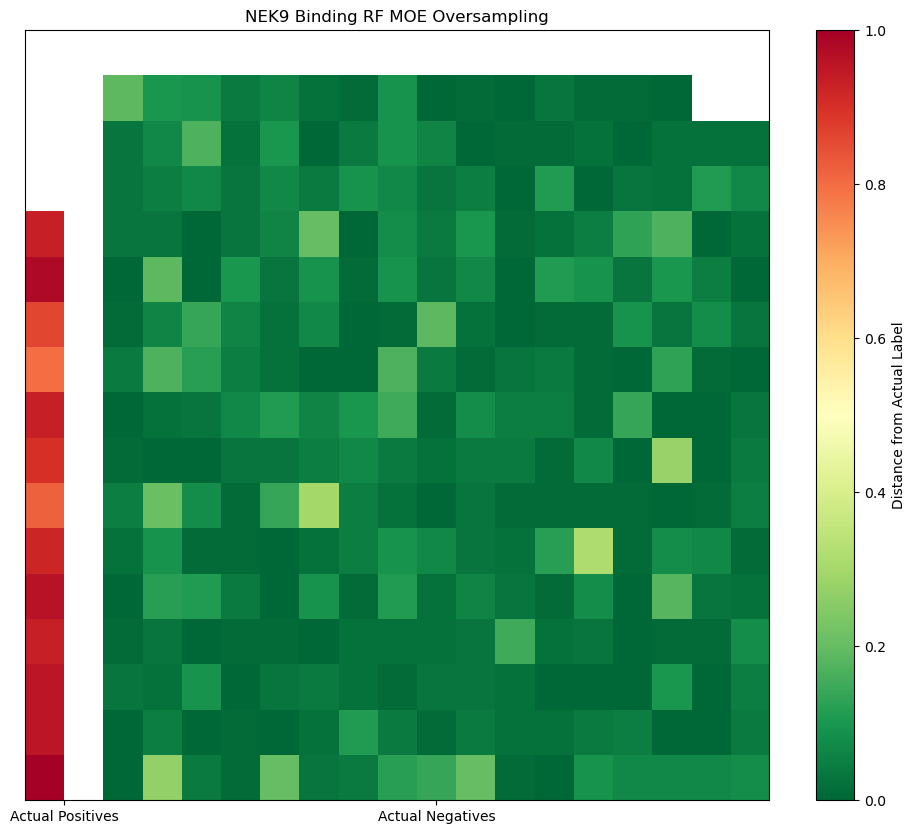

In [28]:
plot_heatmap(testX_torch, testY_torch, model, "NEK9 Binding RF MOE Oversampling")

Test Accuracy: 94.70%


<Figure size 600x400 with 0 Axes>

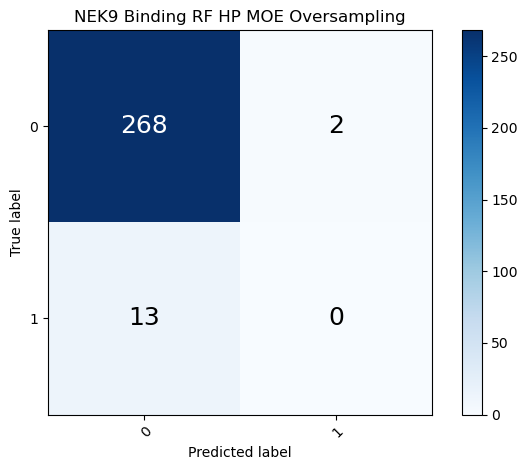

In [29]:
rf_model, testX_np, testY_np, method_type = RF_basic(trainX_bind_moe, trainY_bind_moe, testX_bind_moe, testY_bind_moe, sampling='OS', method='HyperPara')
testY_pred = rf_model.predict(testX_np)
plot_confusion_matrix(testY_bind_moe, testY_pred, ["0", "1"], title="NEK9 Binding RF HP MOE Oversampling")

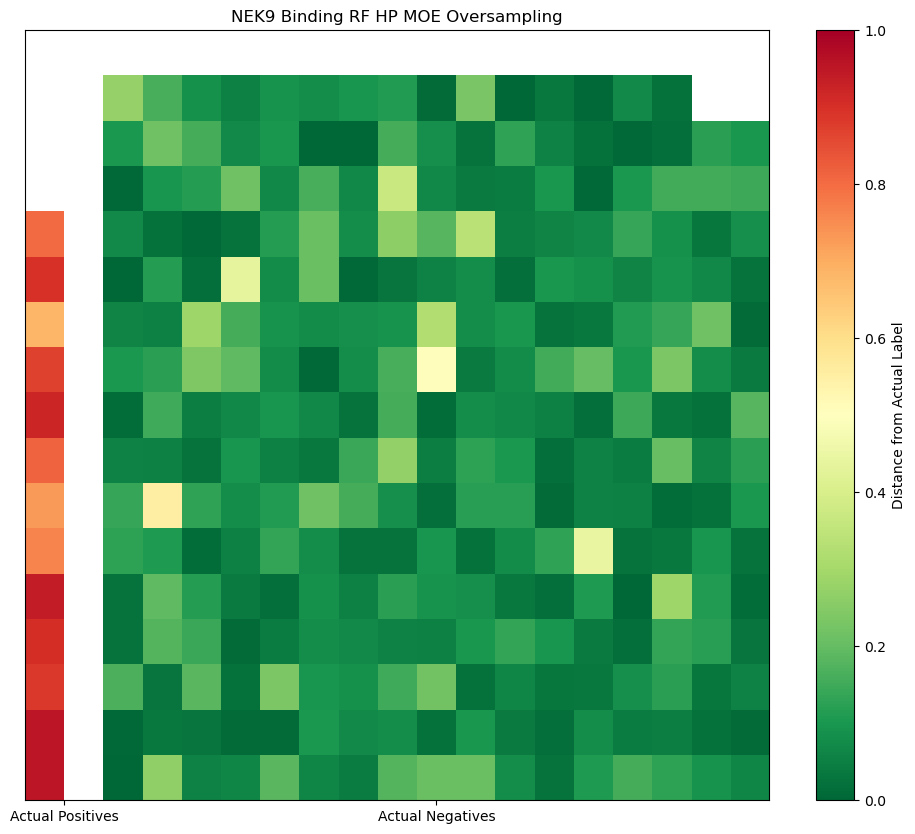

In [30]:
plot_heatmap(testX_np, testY_np, rf_model, "NEK9 Binding RF HP MOE Oversampling")

## Better way to compare the different methods

In [31]:
configs = [
    {'model_type': 'RF', 'descriptor': 'moe', 'sampling': 'OS', 'method': 'HyperPara'},
    {'model_type': 'RF', 'descriptor': 'moe', 'sampling': 'OS', 'method': 'GridSearch'},
    {'model_type': 'RF', 'descriptor': 'MF', 'sampling': 'OS', 'method': 'HyperPara'},
    {'model_type': 'RF', 'descriptor': 'MF', 'sampling': 'OS', 'method': 'GridSearch'},
    {'model_type': 'GP', 'descriptor': 'moe', 'sampling': 'OS', 'method': 'None'},
    {'model_type': 'GP', 'descriptor': 'MF', 'sampling': 'OS', 'method': 'None'},
    {'model_type': 'RF', 'descriptor': 'moe', 'sampling': 'US', 'method': 'HyperPara'},
    {'model_type': 'RF', 'descriptor': 'moe', 'sampling': 'US', 'method': 'GridSearch'},
    {'model_type': 'RF', 'descriptor': 'MF', 'sampling': 'US', 'method': 'HyperPara'},
    {'model_type': 'RF', 'descriptor': 'MF', 'sampling': 'US', 'method': 'GridSearch'},
    {'model_type': 'GP', 'descriptor': 'moe', 'sampling': 'US', 'method': 'None'},
    {'model_type': 'GP', 'descriptor': 'MF', 'sampling': 'US', 'method': 'None'}
]

In [32]:
import pandas as pd

binding_research = pd.DataFrame(columns=['method', 'recall', 'model', 'testX', 'testY'])

In [33]:
from sklearn.metrics import recall_score
import torch

# Loop through configurations with progress outputs
for i, config in enumerate(configs):
    model_type = config['model_type']
    descriptor = config['descriptor']
    sampling = config['sampling']
    method = config['method']

    # Print start of configuration
    print(f"Starting experiment {i+1}/{len(configs)}: {model_type} with {descriptor}, Sampling: {sampling}, Method: {method}")

    # Fetch the data
    trainX = globals()[f'trainX_bind_{descriptor}']
    trainY = globals()[f'trainY_bind_{descriptor}']
    testX = globals()[f'testX_bind_{descriptor}']
    testY = globals()[f'testY_bind_{descriptor}']

    if model_type == 'RF':
        model, testX_np, testY_np, _ = RF_basic(trainX, trainY, testX, testY, sampling=sampling, method=method)
        test_pred = model.predict(testX_np)
    else:  # GP model
        model, testX_np, testY_np, _ = GP_basic(trainX, trainY, testX, testY, method=sampling)
        model.eval()
        test_pred = model(testX_np).loc.max(0)[1].numpy()

    recall_val = recall_score(testY_np, test_pred)

    # Construct the method string
    method_str = f"NEK9_binding_{descriptor}_{model_type}_{sampling}"
    if model_type == 'RF':
        method_str += f"_{method}"

    # Create a new row DataFrame
    new_row = pd.DataFrame({
        'method': [method_str], 
        'recall': [recall_val], 
        'model': [model], 
        'testX': [testX_np], 
        'testY': [testY_np]
    })

    # Append to DataFrame using concat
    binding_research = pd.concat([binding_research, new_row], ignore_index=True)

    # Print end of configuration
    print(f"Completed experiment {i+1}/{len(configs)}: {method_str} with Recall: {recall_val:.2f}")

print("All experiments completed successfully.")

Starting experiment 1/12: RF with moe, Sampling: OS, Method: HyperPara
Test Accuracy: 94.70%
Completed experiment 1/12: NEK9_binding_moe_RF_OS_HyperPara with Recall: 0.00
Starting experiment 2/12: RF with moe, Sampling: OS, Method: GridSearch
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Test Accuracy: 95.05%
Completed experiment 2/12: NEK9_binding_moe_RF_OS_GridSearch with Recall: 0.00
Starting experiment 3/12: RF with MF, Sampling: OS, Method: HyperPara
Test Accuracy: 96.44%
Completed experiment 3/12: NEK9_binding_MF_RF_OS_HyperPara with Recall: 0.25
Starting experiment 4/12: RF with MF, Sampling: OS, Method: GridSearch
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Test Accuracy: 96.80%
Completed experiment 4/12: NEK9_binding_MF_RF_OS_GridSearch with Recall: 0.25
Starting experiment 5/12: GP with moe, Sampling: OS, Method: None
Iter 1/200 - Loss: 6.866
Iter 51/200 - Loss: 3.823
Iter 101/200 - Loss: 3.381
Iter 151/200 - Loss: 3.343
Completed experiment 

In [34]:
print(binding_research)

                               method    recall  \
0    NEK9_binding_moe_RF_OS_HyperPara  0.000000   
1   NEK9_binding_moe_RF_OS_GridSearch  0.000000   
2     NEK9_binding_MF_RF_OS_HyperPara  0.250000   
3    NEK9_binding_MF_RF_OS_GridSearch  0.250000   
4              NEK9_binding_moe_GP_OS  0.000000   
5               NEK9_binding_MF_GP_OS  0.166667   
6    NEK9_binding_moe_RF_US_HyperPara  0.461538   
7   NEK9_binding_moe_RF_US_GridSearch  0.384615   
8     NEK9_binding_MF_RF_US_HyperPara  0.916667   
9    NEK9_binding_MF_RF_US_GridSearch  0.833333   
10             NEK9_binding_moe_GP_US  0.000000   
11              NEK9_binding_MF_GP_US  1.000000   

                                                model  \
0   (DecisionTreeClassifier(max_depth=33, max_feat...   
1   (DecisionTreeClassifier(max_depth=30, max_feat...   
2   (DecisionTreeClassifier(max_depth=28, max_feat...   
3   (DecisionTreeClassifier(max_depth=30, max_feat...   
4   DirichletGPModel(\n  (likelihood): DirichletCl.

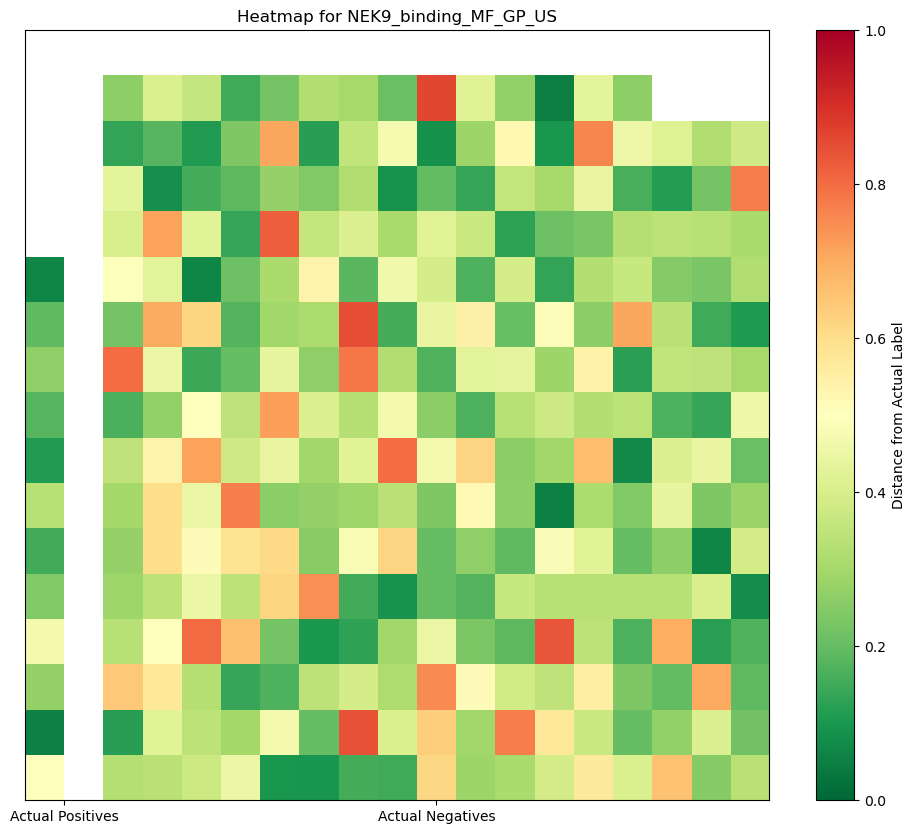

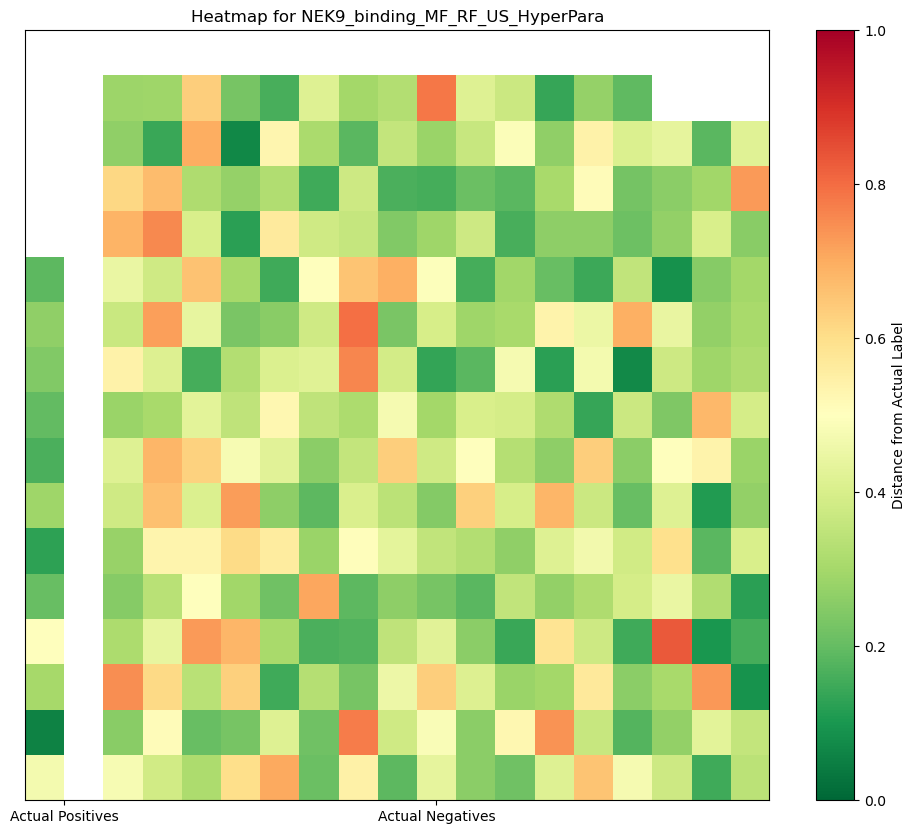

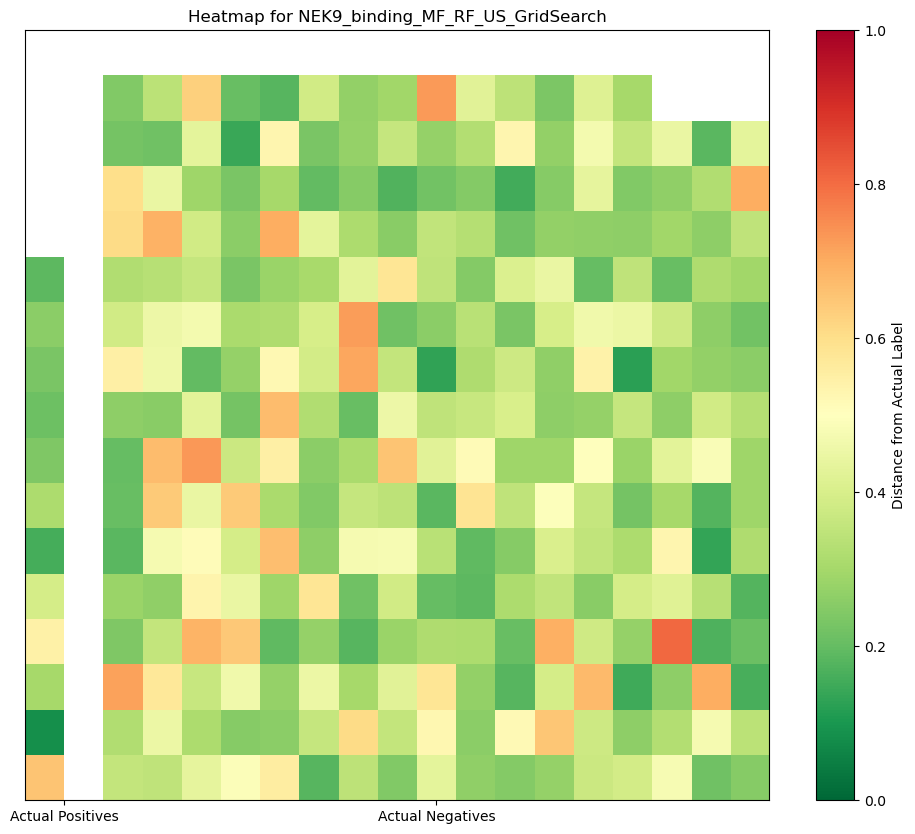

In [35]:
# Get model, testX, testY for each method
methods = ['NEK9_binding_MF_GP_US', 'NEK9_binding_MF_RF_US_HyperPara', 'NEK9_binding_MF_RF_US_GridSearch']
for method in methods:
    row = binding_research[binding_research['method'] == method].iloc[0]
    model = row['model']
    testX = row['testX']
    testY = row['testY']

    # Plot the heatmap
    plot_heatmap(testX, testY, model, f"Heatmap for {method}")

In [36]:
inhibition_research = pd.DataFrame(columns=['method', 'recall', 'model', 'testX', 'testY'])
# Loop through configurations with progress outputs
for i, config in enumerate(configs):
    model_type = config['model_type']
    descriptor = config['descriptor']
    sampling = config['sampling']
    method = config['method']

    # Print start of configuration
    print(f"Starting experiment {i+1}/{len(configs)}: {model_type} with {descriptor}, Sampling: {sampling}, Method: {method}")

    # Fetch the data
    trainX = globals()[f'trainX_inhib_{descriptor}']
    trainY = globals()[f'trainY_inhib_{descriptor}']
    testX = globals()[f'testX_inhib_{descriptor}']
    testY = globals()[f'testY_inhib_{descriptor}']

    if model_type == 'RF':
        model, testX_np, testY_np, _ = RF_basic(trainX, trainY, testX, testY, sampling=sampling, method=method)
        test_pred = model.predict(testX_np)
    else:  # GP model
        model, testX_np, testY_np, _ = GP_basic(trainX, trainY, testX, testY, method=sampling)
        model.eval()
        test_pred = model(testX_np).loc.max(0)[1].numpy()

    recall_val = recall_score(testY_np, test_pred)

    # Construct the method string
    method_str = f"NEK9_inhibition_{descriptor}_{model_type}_{sampling}"
    if model_type == 'RF':
        method_str += f"_{method}"

    # Create a new row DataFrame
    new_row = pd.DataFrame({
        'method': [method_str], 
        'recall': [recall_val], 
        'model': [model], 
        'testX': [testX_np], 
        'testY': [testY_np]
    })

    # Append to DataFrame using concat
    inhibition_research = pd.concat([inhibition_research, new_row], ignore_index=True)

    # Print end of configuration
    print(f"Completed experiment {i+1}/{len(configs)}: {method_str} with Recall: {recall_val:.2f}")

print("All experiments completed successfully.")

Starting experiment 1/12: RF with moe, Sampling: OS, Method: HyperPara
Test Accuracy: 96.25%
Completed experiment 1/12: NEK9_inhibition_moe_RF_OS_HyperPara with Recall: 0.78
Starting experiment 2/12: RF with moe, Sampling: OS, Method: GridSearch
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Test Accuracy: 96.25%
Completed experiment 2/12: NEK9_inhibition_moe_RF_OS_GridSearch with Recall: 0.78
Starting experiment 3/12: RF with MF, Sampling: OS, Method: HyperPara
Test Accuracy: 93.59%
Completed experiment 3/12: NEK9_inhibition_MF_RF_OS_HyperPara with Recall: 0.88
Starting experiment 4/12: RF with MF, Sampling: OS, Method: GridSearch
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Test Accuracy: 93.59%
Completed experiment 4/12: NEK9_inhibition_MF_RF_OS_GridSearch with Recall: 0.88
Starting experiment 5/12: GP with moe, Sampling: OS, Method: None
Iter 1/200 - Loss: 6.956
Iter 51/200 - Loss: 4.047
Iter 101/200 - Loss: 3.459
Iter 151/200 - Loss: 3.408
Completed

In [37]:
print(inhibition_research)

                                  method    recall  \
0    NEK9_inhibition_moe_RF_OS_HyperPara  0.777778   
1   NEK9_inhibition_moe_RF_OS_GridSearch  0.777778   
2     NEK9_inhibition_MF_RF_OS_HyperPara  0.875000   
3    NEK9_inhibition_MF_RF_OS_GridSearch  0.875000   
4              NEK9_inhibition_moe_GP_OS  0.777778   
5               NEK9_inhibition_MF_GP_OS  0.875000   
6    NEK9_inhibition_moe_RF_US_HyperPara  0.777778   
7   NEK9_inhibition_moe_RF_US_GridSearch  0.777778   
8     NEK9_inhibition_MF_RF_US_HyperPara  0.875000   
9    NEK9_inhibition_MF_RF_US_GridSearch  0.875000   
10             NEK9_inhibition_moe_GP_US  0.000000   
11              NEK9_inhibition_MF_GP_US  0.875000   

                                                model  \
0   (DecisionTreeClassifier(max_depth=20, max_feat...   
1   (DecisionTreeClassifier(max_depth=10, max_feat...   
2   (DecisionTreeClassifier(max_depth=35, max_feat...   
3   (DecisionTreeClassifier(max_depth=20, max_feat...   
4   Dirichle

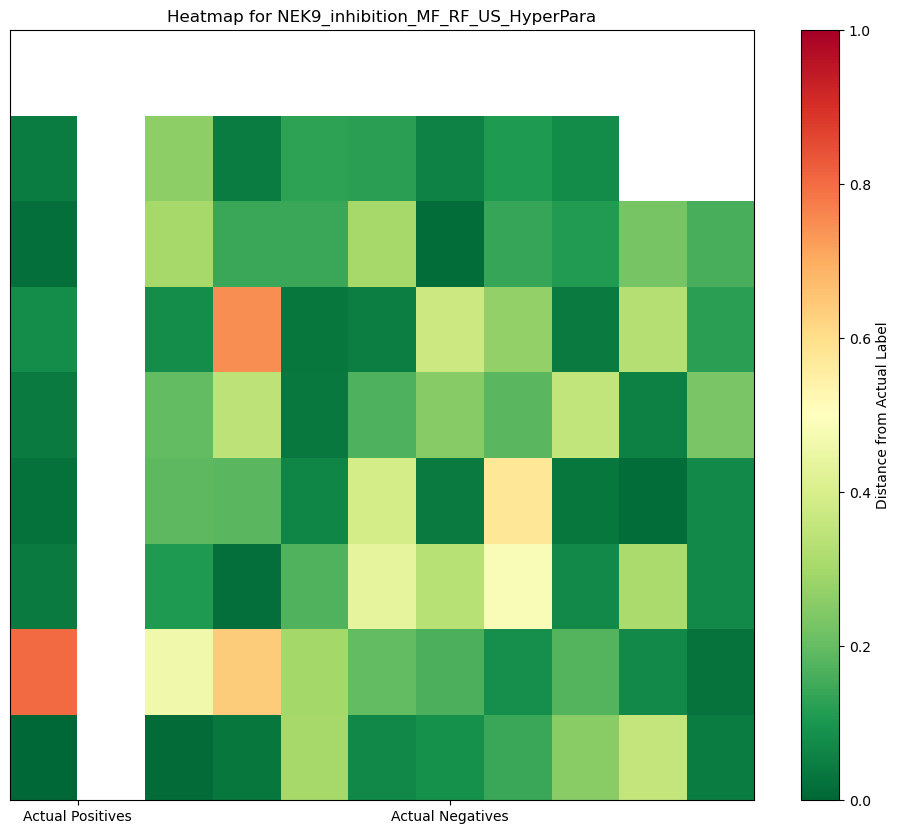

/home/chongyef/miniconda3/envs/atom2024/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


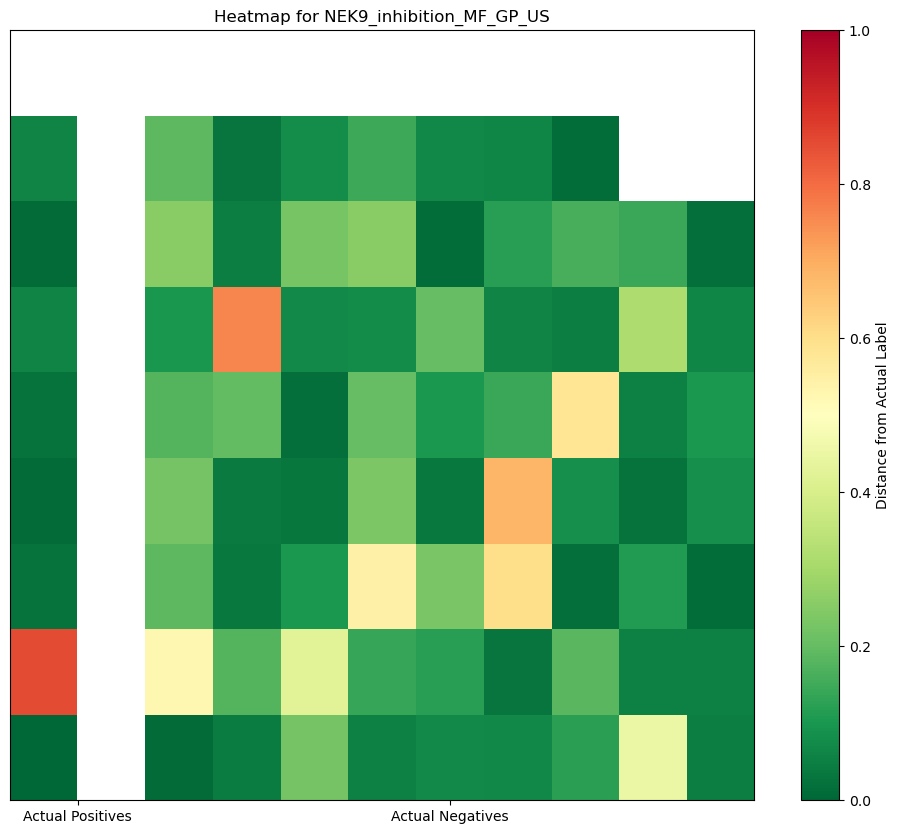

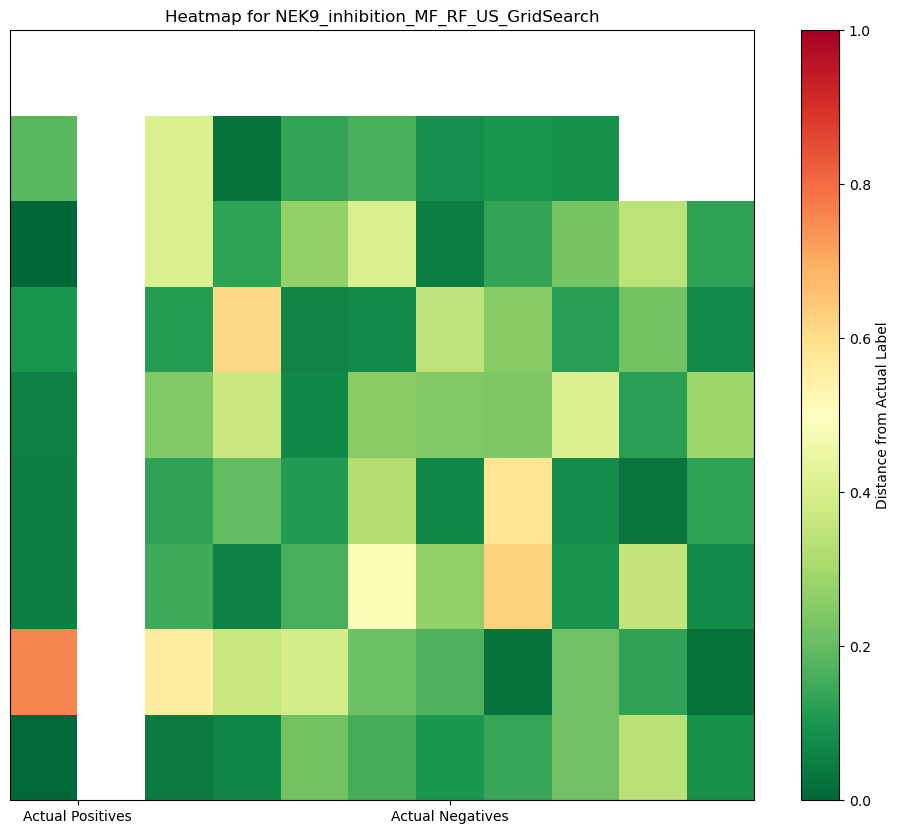

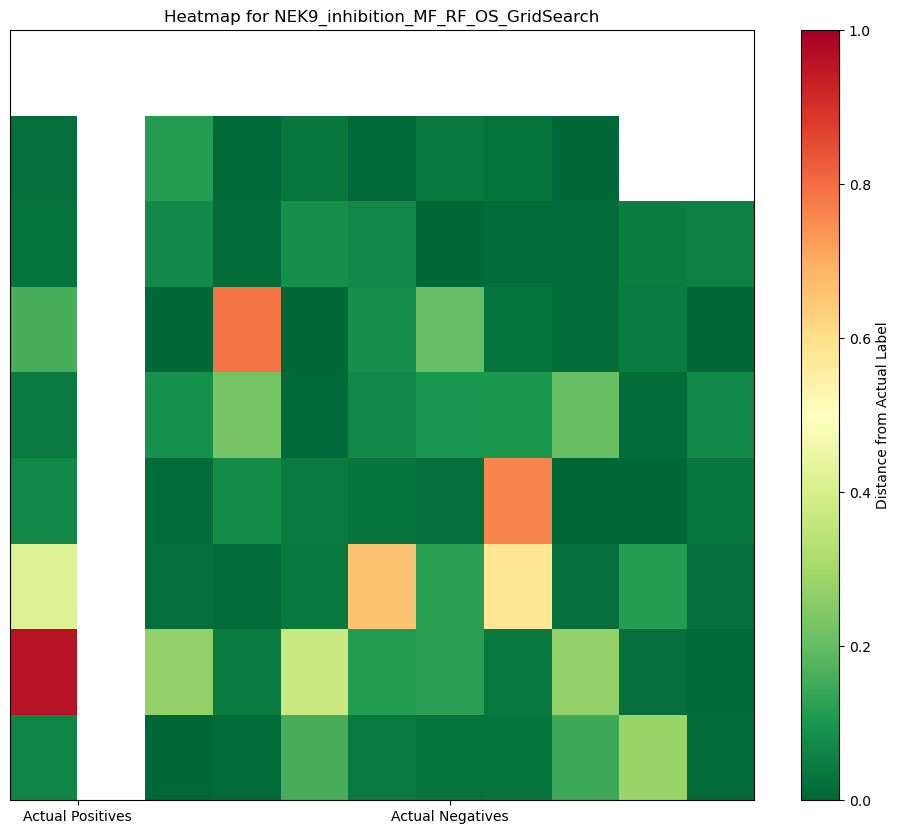

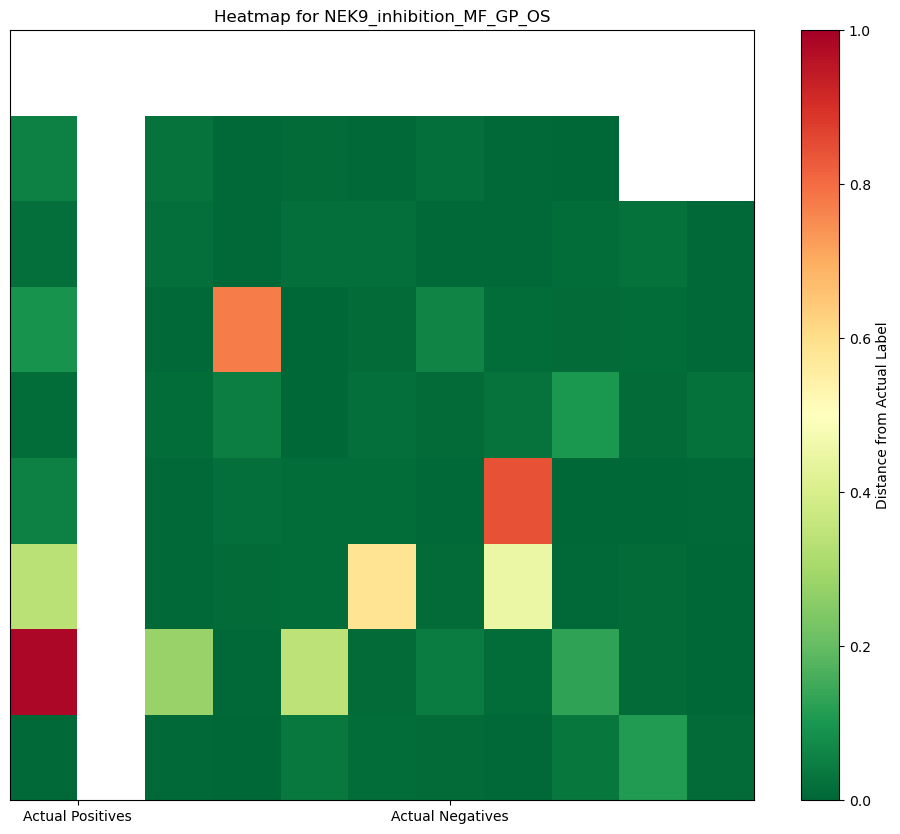

In [38]:
# Get model, testX, testY for each method
methods = ['NEK9_inhibition_MF_RF_US_HyperPara', 'NEK9_inhibition_MF_GP_US', 'NEK9_inhibition_MF_RF_US_GridSearch', 'NEK9_inhibition_MF_RF_OS_GridSearch', 'NEK9_inhibition_MF_GP_OS']
for method in methods:
    row = inhibition_research[inhibition_research['method'] == method].iloc[0]
    model = row['model']
    testX = row['testX']
    testY = row['testY']

    # Plot the heatmap
    plot_heatmap(testX, testY, model, f"Heatmap for {method}")

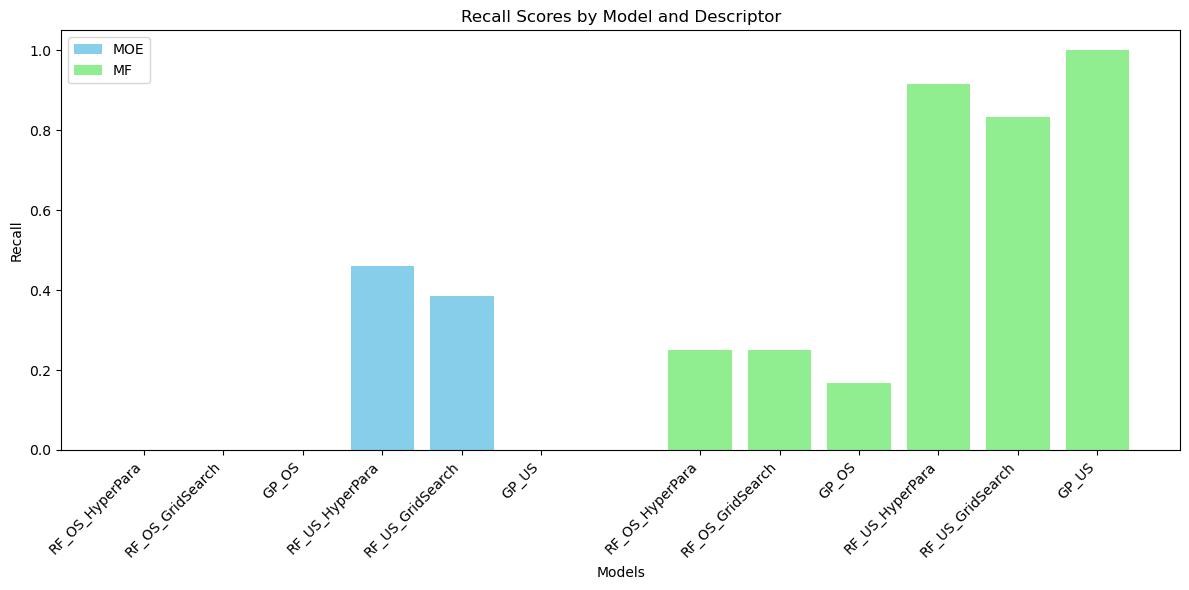

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting relevant data for 'moe' and 'MF' descriptors
moe_data = binding_research[binding_research['method'].str.contains('_moe_')]
mf_data = binding_research[binding_research['method'].str.contains('_MF_')]

# Model names simplified for the x-axis
moe_labels = moe_data['method'].str.replace('NEK9_binding_moe_', '').tolist()
mf_labels = mf_data['method'].str.replace('NEK9_binding_MF_', '').tolist()

# Recall scores
moe_recalls = moe_data['recall'].tolist()
mf_recalls = mf_data['recall'].tolist()

# Positions of bars on x-axis
x_moe = np.arange(len(moe_labels))  # the label locations for moe
x_mf = np.arange(len(mf_labels)) + len(moe_labels) + 1  # the label locations for MF, with a gap between moe and MF

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plotting the bars
ax.bar(x_moe, moe_recalls, width=0.8, label='MOE', color='skyblue')
ax.bar(x_mf, mf_recalls, width=0.8, label='MF', color='lightgreen')

# Labeling
ax.set_xlabel('Models')
ax.set_ylabel('Recall')
ax.set_title('Recall Scores by Model and Descriptor')
ax.set_xticks(np.concatenate([x_moe, x_mf]))  # Combine the x positions for MOE and MF
ax.set_xticklabels(moe_labels + mf_labels, rotation=45, ha="right")  # Combine labels and rotate for better readability

# Adding a legend
ax.legend()

# Show the plot
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()


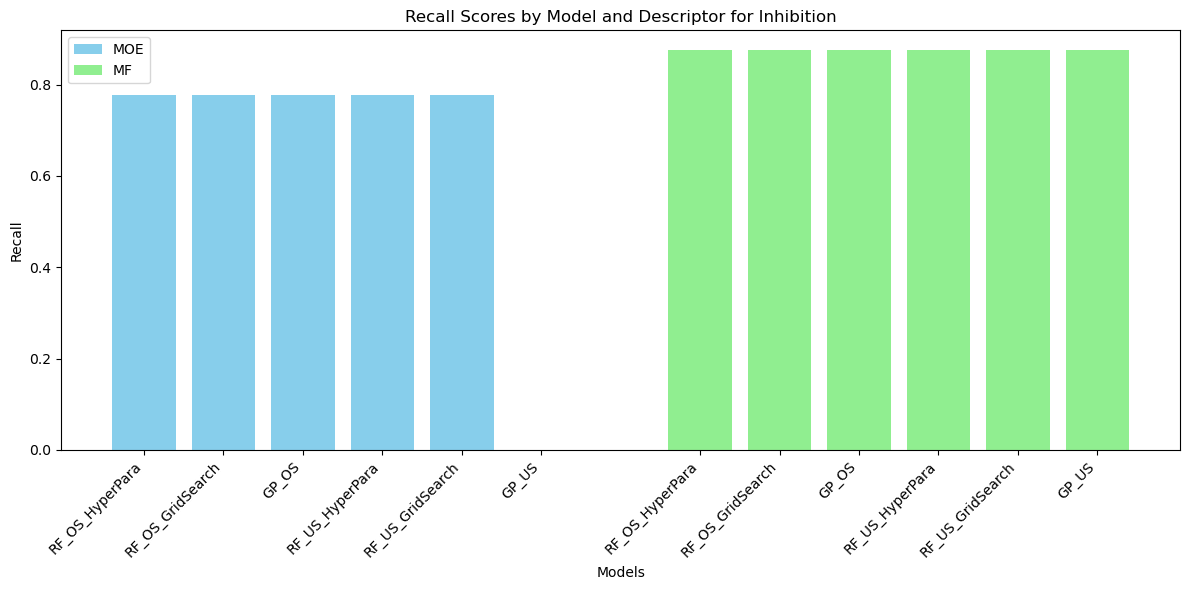

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting relevant data for 'moe' and 'MF' descriptors
moe_data = inhibition_research[inhibition_research['method'].str.contains('_moe_')]
mf_data = inhibition_research[inhibition_research['method'].str.contains('_MF_')]

# Model names simplified for the x-axis
moe_labels = moe_data['method'].str.replace('NEK9_inhibition_moe_', '').tolist()
mf_labels = mf_data['method'].str.replace('NEK9_inhibition_MF_', '').tolist()

# Recall scores
moe_recalls = moe_data['recall'].tolist()
mf_recalls = mf_data['recall'].tolist()

# Positions of bars on x-axis
x_moe = np.arange(len(moe_labels))  # the label locations for moe
x_mf = np.arange(len(mf_labels)) + len(moe_labels) + 1  # the label locations for MF, with a gap between moe and MF

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plotting the bars
ax.bar(x_moe, moe_recalls, width=0.8, label='MOE', color='skyblue')
ax.bar(x_mf, mf_recalls, width=0.8, label='MF', color='lightgreen')

# Labeling
ax.set_xlabel('Models')
ax.set_ylabel('Recall')
ax.set_title('Recall Scores by Model and Descriptor for Inhibition')
ax.set_xticks(np.concatenate([x_moe, x_mf]))  # Combine the x positions for MOE and MF
ax.set_xticklabels(moe_labels + mf_labels, rotation=45, ha="right")  # Combine labels and rotate for better readability

# Adding a legend
ax.legend()

# Show the plot
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()

In [41]:
import os
import joblib

# Directory to save models
model_dir = '../models'
os.makedirs(model_dir, exist_ok=True)  # Create directory if it doesn't exist

# DataFrame assumed to be named as research_df and having columns 'model' and 'method'
for index, row in binding_research.iterrows():
    model = row['model']
    method = row['method']
    filename = os.path.join(model_dir, f"{method}.pkl")  # Construct filename
    joblib.dump(model, filename)  # Save the model
    print(f"Model saved to {filename}")  # Optional: print confirmation message

Model saved to ../models/NEK9_binding_moe_RF_OS_HyperPara.pkl
Model saved to ../models/NEK9_binding_moe_RF_OS_GridSearch.pkl
Model saved to ../models/NEK9_binding_MF_RF_OS_HyperPara.pkl
Model saved to ../models/NEK9_binding_MF_RF_OS_GridSearch.pkl
Model saved to ../models/NEK9_binding_moe_GP_OS.pkl
Model saved to ../models/NEK9_binding_MF_GP_OS.pkl
Model saved to ../models/NEK9_binding_moe_RF_US_HyperPara.pkl
Model saved to ../models/NEK9_binding_moe_RF_US_GridSearch.pkl
Model saved to ../models/NEK9_binding_MF_RF_US_HyperPara.pkl
Model saved to ../models/NEK9_binding_MF_RF_US_GridSearch.pkl
Model saved to ../models/NEK9_binding_moe_GP_US.pkl
Model saved to ../models/NEK9_binding_MF_GP_US.pkl


In [42]:
# DataFrame assumed to be named as research_df and having columns 'model' and 'method'
for index, row in inhibition_research.iterrows():
    model = row['model']
    method = row['method']
    filename = os.path.join(model_dir, f"{method}.pkl")  # Construct filename
    joblib.dump(model, filename)  # Save the model
    print(f"Model saved to {filename}")  # Optional: print confirmation message

Model saved to ../models/NEK9_inhibition_moe_RF_OS_HyperPara.pkl
Model saved to ../models/NEK9_inhibition_moe_RF_OS_GridSearch.pkl
Model saved to ../models/NEK9_inhibition_MF_RF_OS_HyperPara.pkl
Model saved to ../models/NEK9_inhibition_MF_RF_OS_GridSearch.pkl
Model saved to ../models/NEK9_inhibition_moe_GP_OS.pkl
Model saved to ../models/NEK9_inhibition_MF_GP_OS.pkl
Model saved to ../models/NEK9_inhibition_moe_RF_US_HyperPara.pkl
Model saved to ../models/NEK9_inhibition_moe_RF_US_GridSearch.pkl
Model saved to ../models/NEK9_inhibition_MF_RF_US_HyperPara.pkl
Model saved to ../models/NEK9_inhibition_MF_RF_US_GridSearch.pkl
Model saved to ../models/NEK9_inhibition_moe_GP_US.pkl
Model saved to ../models/NEK9_inhibition_MF_GP_US.pkl


How to use the saved models:

In [ ]:
# import joblib

# # Path to the model file
# model_file = '../models/NEK9_binding_moe_RF_OS_HyperPara.pkl'

# # Load the model from the file
# model = joblib.load(model_file)

# # Assuming you have some data to predict
# # Make sure this data is preprocessed in the same way as the training data for the model
# # Example data in the form of a NumPy array or similar structure that your model expects
# X_new = ...  # your new data to predict

# # Make predictions
# predictions = model.predict(X_new)

# # Output predictions
# print(predictions)
